In [0]:
# import libraries
import json
import math
import os
from glob import glob 
from tqdm import tqdm
from PIL import Image
import cv2 # image processing
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization
import tensorflow as tf

from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.applications import VGG16
from keras.utils.np_utils import to_categorical
from keras.layers import  Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator,image,img_to_array,load_img
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
input_dir = '/content/drive/My Drive/chest_xray_4471/'
train_dir = input_dir +"train/"
test_dir = input_dir +"test/"
val_dir = input_dir +"val/"

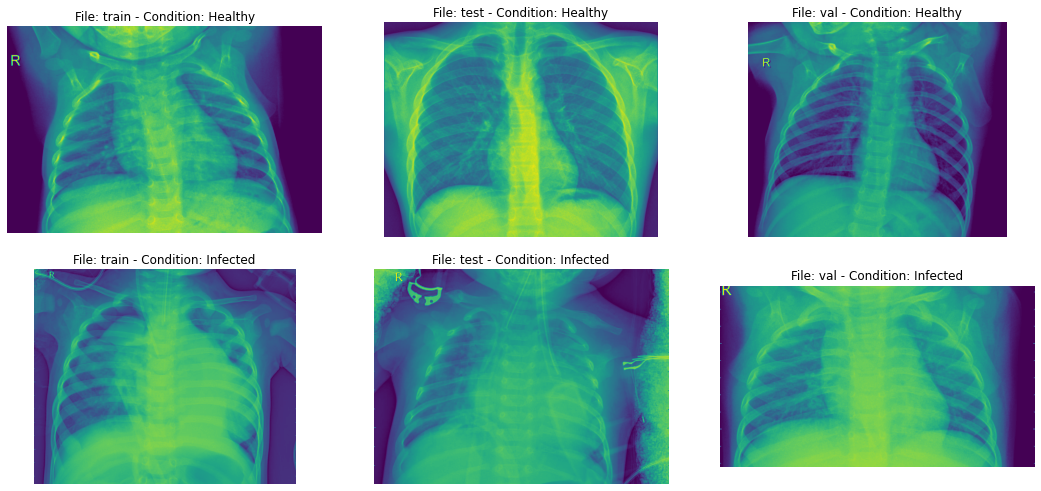

In [0]:
fig, ax = plt.subplots(2,3, figsize=(15,7))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['train','test','val']):
    set_path = input_dir+_set
    ax[i].axis('off')
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]))
    ax[i].set_title('File: {} - Condition: Healthy'.format(_set))
    ax[i+3].axis('off')
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]))
    ax[i+3].set_title('File: {} - Condition: Infected'.format(_set))

In [0]:
# Data Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical', shuffle = False)
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
# Create VGG16 Model with Keras library

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation="softmax"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['acc']
    )
    return model

vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model = build_model(vgg16 ,lr = 1e-4)
model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_______________________________________________________

In [0]:
# Fit Model
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='/content/drive/My Drive/chest_xray_4471/best_model_todate_vgg2', save_best_only=True, save_weights_only=True)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=10, callbacks=[es, chkpt]
)

Epoch 1/10
100/100 [==============================] - 877s 9s/step - loss: 0.5664 - acc: 0.7465 - val_loss: 1.6420 - val_acc: 0.5000
Epoch 2/10
100/100 [==============================] - 913s 9s/step - loss: 0.4165 - acc: 0.7600 - val_loss: 2.1902 - val_acc: 0.5625
Epoch 3/10
  5/100 [>.............................] - ETA: 12:38 - loss: 0.3110 - acc: 0.8100

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 226 could not be retrieved. It could be because a worker has died.
  UserWarning)


100/100 [==============================] - 593s 6s/step - loss: 0.4447 - acc: 0.7050 - val_loss: 1.4641 - val_acc: 0.5625
Epoch 4/10
100/100 [==============================] - 39s 388ms/step - loss: 0.3780 - acc: 0.8240 - val_loss: 0.6160 - val_acc: 0.6875
Epoch 5/10
100/100 [==============================] - 39s 391ms/step - loss: 0.3166 - acc: 0.8602 - val_loss: 1.4162 - val_acc: 0.6250
Epoch 6/10
100/100 [==============================] - 39s 386ms/step - loss: 0.2932 - acc: 0.8778 - val_loss: 0.9175 - val_acc: 0.7500
Epoch 7/10
100/100 [==============================] - 40s 398ms/step - loss: 0.2790 - acc: 0.8840 - val_loss: 0.4503 - val_acc: 0.8125
Epoch 8/10
100/100 [==============================] - 39s 392ms/step - loss: 0.2646 - acc: 0.8835 - val_loss: 1.2637 - val_acc: 0.7500
Epoch 9/10
100/100 [==============================] - 38s 384ms/step - loss: 0.2419 - acc: 0.8930 - val_loss: 0.3848 - val_acc: 0.8125
Epoch 10/10
100/100 [==============================] - 39s 391ms/ste

In [0]:
# Fit Model
es = EarlyStopping(patience=10)
chkpt = ModelCheckpoint(filepath='/content/drive/My Drive/chest_xray_4471/best_model_todate_vgg2', save_best_only=True, save_weights_only=True)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=10, callbacks=[es, chkpt]
)

Epoch 1/20
100/100 [==============================] - 597s 6s/step - loss: 0.4179 - acc: 0.7971 - val_loss: 1.1268 - val_acc: 0.6250
Epoch 2/20
100/100 [==============================] - 613s 6s/step - loss: 0.3499 - acc: 0.8380 - val_loss: 0.4939 - val_acc: 0.7500
Epoch 3/20
100/100 [==============================] - 388s 4s/step - loss: 0.2875 - acc: 0.8665 - val_loss: 0.4797 - val_acc: 0.7500
Epoch 4/20
100/100 [==============================] - 34s 342ms/step - loss: 0.2853 - acc: 0.8712 - val_loss: 1.4051 - val_acc: 0.6250
Epoch 5/20
100/100 [==============================] - 34s 338ms/step - loss: 0.2494 - acc: 0.8950 - val_loss: 0.6963 - val_acc: 0.6875
Epoch 6/20
100/100 [==============================] - 34s 343ms/step - loss: 0.2332 - acc: 0.9025 - val_loss: 1.5063 - val_acc: 0.5625
Epoch 7/20
100/100 [==============================] - 34s 342ms/step - loss: 0.2120 - acc: 0.9195 - val_loss: 0.6349 - val_acc: 0.6875
Epoch 8/20
100/100 [==============================] - 34s 344

In [0]:
model.load_weights("/content/drive/My Drive/chest_xray_4471/best_model_todate_vgg2")

In [0]:
labels = (test_generator.classes)
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size+1
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

32/32 [==============================] - 7s 227ms/step


In [0]:
predd = np.argmax(pred, axis = -1)
#print(labels)

In [0]:
tp = 0
tn = 0
fp = 0
fn = 0
for i in range(624):
  if predd[i] == labels[i]:
    if predd[i] == 1:
      tp+=1
    else:
      tn+=1
  else:
    if predd[i] == 1:
      fp+=1
    else:
      fn+=1
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("precision is:", precision)
print("recall is:", recall)

precision is: 0.897196261682243
recall is: 0.9846153846153847


In [0]:
test_loss, test_score = model.evaluate(test_generator)
print("test loss is:", test_loss)
print("test accuracy is:", test_score)

32/32 [==============================] - 7s 223ms/step
test loss is: 0.28441184759140015
test accuracy is: 0.9198718070983887


In [0]:
from mlxtend.plotting import plot_confusion_matrix

<Figure size 432x288 with 0 Axes>

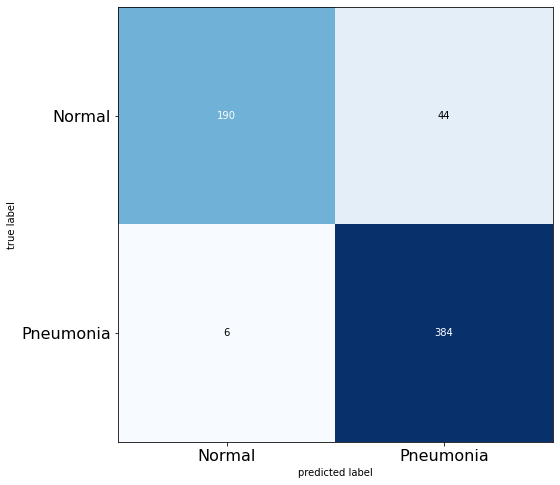

In [0]:
cm = confusion_matrix(labels,predd)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [0]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.98
Precision of the model is 0.90


In [0]:
test_loss, test_score = model.evaluate(test_generator)
print("loss:", test_loss)
print("accuracy:", test_score)

32/32 [==============================] - 7s 204ms/step
loss: 0.3951490521430969
accuracy: 0.9246794581413269


In [0]:
# model save
model.save_weights("/content/drive/My Drive/chest_xray_4471/vgg16-example-pneumonia.h5")